# Portfolio Optimization Using Python

This project takes a look at portfolio optimization by using the Sharpe ratio. The overall objective is to see if my personal portfolio managed by a robo-advisor is allocated in the most optimal way.

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
from fredapi import Fred
import matplotlib.pyplot as plt

## 1. Set-up Tickers and Time Range

The ETFs chosen by my roboadvisor:
* VTI: US stocks
* VNQ: Real estate
* LQD: Corporate bonds
* VWO: Emerging market stocks
* VEA: foreign developed stocks
* EMB: foreign market bonds

As such, I will use these same tickers.

In [85]:
tickers = ["VTI", "VNQ", "LQD", "VWO", "VEA", "EMB"]

In [87]:
end_date = datetime.today()

In [88]:
start_date = end_date - timedelta(days=5*365)
start_date

datetime.datetime(2019, 11, 6, 22, 37, 56, 302636)

In [89]:
# adjusted close excludes dividends, etc.
adjusted_close_df = pd.DataFrame()

In [90]:
# download data
for ticker in tickers: 
    data = yf.download(ticker, start=start_date, end= end_date)
    adjusted_close_df[ticker] = data["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [91]:
adjusted_close_df

,VTI,VNQ,LQD,VWO,VEA,EMB
Date,,,,,,
2019-11-07 00:00:00+00:00,144.930283,75.551620,107.107056,37.469040,37.300591,89.814690
2019-11-08 00:00:00+00:00,145.337189,75.369598,106.962402,37.131081,37.222790,89.942825
2019-11-11 00:00:00+00:00,145.050522,75.535095,106.996429,36.923126,37.188213,89.870773
2019-11-12 00:00:00+00:00,145.300171,74.964157,107.098564,36.645828,37.196854,89.686623
2019-11-13 00:00:00+00:00,145.364929,75.650925,107.353806,36.411865,37.075821,89.550583
...,...,...,...,...,...,...
2024-10-29 00:00:00+00:00,287.079987,95.349998,108.963730,47.009998,50.709999,91.135033
2024-10-30 00:00:00+00:00,286.369995,95.769997,108.824226,46.669998,50.459999,91.035492
2024-10-31 00:00:00+00:00,281.029999,94.150002,108.605003,46.570000,50.099998,90.498001


## 2. Calculate Log Normal Returns

In [92]:
log_returns = np.log(adjusted_close_df / adjusted_close_df.shift(1))

In [93]:
log_returns = log_returns.dropna()

## 3. Calculate Covariance Matrix

In [94]:
covariance_matrix = log_returns.cov()*252
covariance_matrix

,VTI,VNQ,LQD,VWO,VEA,EMB
VTI,0.046656,0.045360,0.008629,0.035719,0.038743,0.017551
VNQ,0.045360,0.066178,0.011694,0.034346,0.039526,0.020558
LQD,0.008629,0.011694,0.012295,0.007417,0.008377,0.009903
VWO,0.035719,0.034346,0.007417,0.045921,0.036558,0.016933
VEA,0.038743,0.039526,0.008377,0.036558,0.040590,0.017668
EMB,0.017551,0.020558,0.009903,0.016933,0.017668,0.016341


## 4. Set-up Portfolio Metrics

### Standard Deviation (risk)

In [95]:
def std_dev(weights, covariance_matrix):
    variance = weights.T @ covariance_matrix @ weights

    return np.sqrt(variance)

### Calculate expected return

In [96]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

### Calculate Sharpe Ratio

In [97]:
def sharpe_ratio(weights, log_returns, covariance_matrix, risk_free_rate):
    sharpe_ratio_final = (expected_return(weights, log_returns) - risk_free_rate) / std_dev(weights, covariance_matrix)

    return sharpe_ratio_final

In [98]:
risk_free_rate = 0.04

In [99]:
# fred = Fred(api_key="")
# ten_year = fred.get_series_last_release("GS10") / 100 #div by 100 to get percentage

# risk_free_rate = ten_year.iloc[-1]
# print(risk_free_rate)

## 5. Optimize Portfolio
In this section, I am optimizing the portfolio by minimizing the negative Sharpe ratio.

In [100]:
def neg_sharpe_ratio(weights, log_returns, covariance_matrix, risk_free_rate):
    neg_sharpe_ratio_final = -sharpe_ratio(weights, log_returns, covariance_matrix, risk_free_rate)

    return neg_sharpe_ratio_final

In [101]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1} # make sure weights add up to 1
bounds = [(0, 0.45) for _ in range(len(tickers))] # 0 as lower bound means we can't go short # 0.4, any one asset can't be more than 40%

In [102]:
initial_weights = np.array([1/len(tickers)]*len(tickers)) 
initial_weights

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

## 6. Analyze Optimized Portfolio

In [103]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, covariance_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.25633818891731364
       x: [ 4.500e-01  0.000e+00  6.345e-17  1.000e-01  4.500e-01
            3.285e-18]
     nit: 4
     jac: [-3.976e-01  4.482e-02  3.759e-02  1.509e-02 -4.840e-02
            1.036e-01]
    nfev: 28
    njev: 4

* VTI: 0.43
* VNQ: 0.13
* LQD: 0.13
* VWO: 0.10
* VEA: 0.10
* EMB: 0.11

In [104]:
optimal_weights = optimized_results.x
optimal_weights

array([4.50000000e-01, 0.00000000e+00, 6.34516973e-17, 1.00000000e-01,
       4.50000000e-01, 3.28488186e-18])

In [105]:
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = std_dev(optimal_weights, covariance_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, covariance_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

VTI: 0.4500
VNQ: 0.0000
LQD: 0.0000
VWO: 0.1000
VEA: 0.4500
EMB: 0.0000
Expected Annual Return: 0.0915
Expected Volatility: 0.2008
Sharpe Ratio: 0.2563


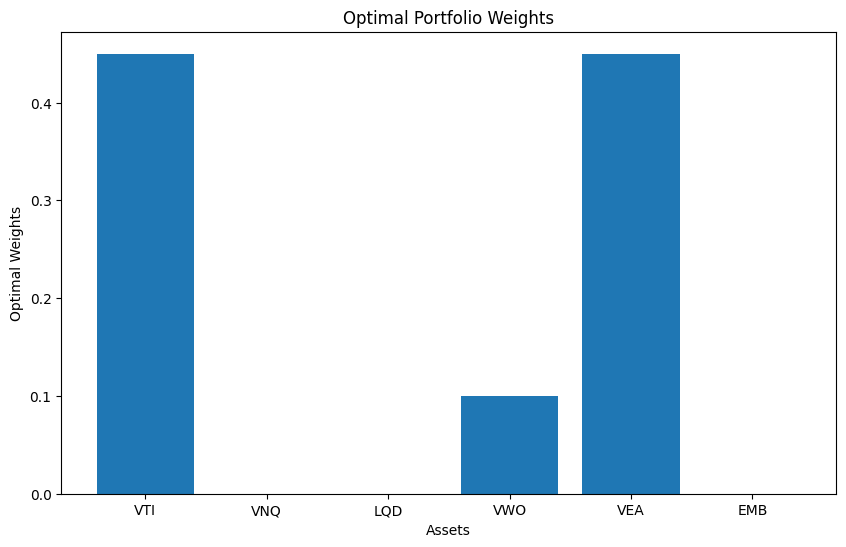

In [106]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

From this, it is clear that the only 3 ETFs I should be invested in are VTI, VWO, VEA. While that may be the optimal allocation, some not considered are my personal risk tolerance and diversification.